In [18]:
#Maria Jimena Vargas López

import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.measure import find_contours
import matplotlib.pyplot as plt

In [19]:

def fourierdes(contour, num_descriptors=16):
    """Calcula descriptores de Fourier a partir de un contorno"""
    contour_complex = contour[:, 0] + 1j * contour[:, 1]
    fft_result = np.fft.fft(contour_complex)
    descriptors = np.abs(fft_result)[:num_descriptors]
    return descriptors

# Configuración
K = 7  # número de clases
N = 50  # número máximo de imágenes por clase
M = 16  # número de descriptores de Fourier

X = np.zeros((K*N, M))  # Matriz de características
y = np.zeros((K*N,))    # Vector de etiquetas

# Ruta base
base_path = "/content/drive/MyDrive/VISIÓN POR COMPUTADORA/SEGMENTADAS_7CLASES"

# Obtener lista de carpetas/clases
class_folders = sorted([f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])

t = 0
for class_idx, folder in enumerate(class_folders):
    folder_path = os.path.join(base_path, folder)
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for i, img_file in enumerate(image_files[:N]):  # Limitar a N imágenes por clase
        img_path = os.path.join(folder_path, img_file)

        try:
            # Leer imagen (ya segmentada)
            img = imread(img_path, as_gray=True)

            # Encontrar contorno (asumiendo que el objeto es blanco sobre fondo negro)
            contours = find_contours(img, 0.5)  # Threshold de 0.5 para separar objeto/fondo

            if len(contours) == 0:
                print(f"Advertencia: No se encontraron contornos en {img_path}")
                continue

            # Tomar el contorno más largo
            contour = max(contours, key=len)

            # Calcular descriptores de Fourier
            f = fourierdes(contour, num_descriptors=M)
            f = f / np.linalg.norm(f)  # Normalización

            X[t, :] = f
            y[t] = class_idx
            t += 1

        except Exception as e:
            print(f"Error procesando {img_path}: {str(e)}")
            continue

# Ajustar el tamaño final en caso de que alguna clase tenga menos imágenes
X = X[:t, :]
y = y[:t]

print(f"Procesadas {t} imágenes de {K} clases")
print(f"Matriz de características X: {X.shape}")
print(f"Vector de etiquetas y: {y.shape}")

Procesadas 334 imágenes de 7 clases
Matriz de características X: (334, 16)
Vector de etiquetas y: (334,)


Descritores de Fourier seleccionados: (0, 1)


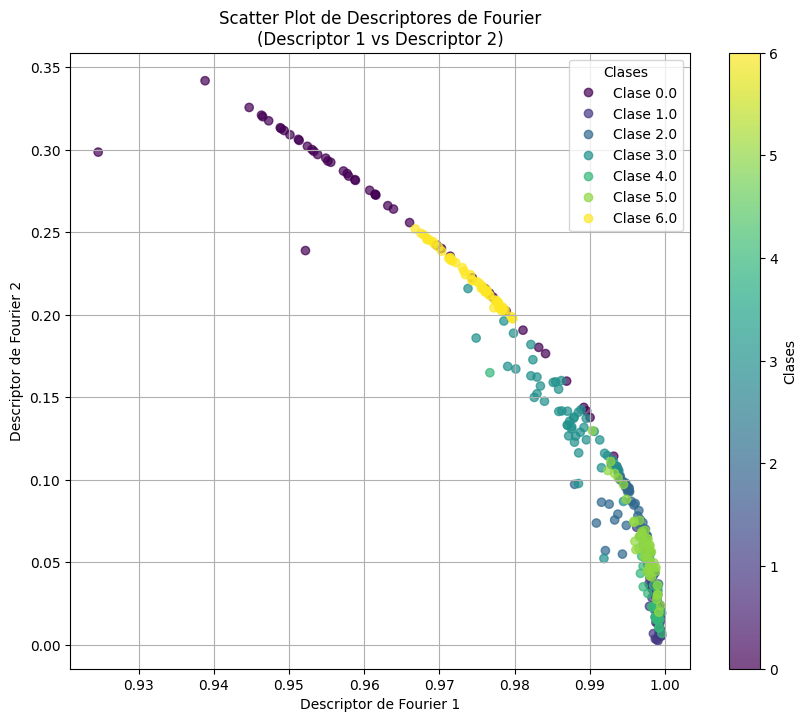

In [20]:
f1 = 0  # Primer descriptor
f2 = 1  # Segundo descriptor

print('Descritores de Fourier seleccionados: '+str((f1,f2)))

# Extraer los dos descriptores
Xs = X[:,[f1,f2]]

# Crear el scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(Xs[:,0], Xs[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Clases')
plt.xlabel(f'Descriptor de Fourier {f1+1}')
plt.ylabel(f'Descriptor de Fourier {f2+1}')
plt.title('Scatter Plot de Descriptores de Fourier\n(Descriptor 1 vs Descriptor 2)')
plt.grid(True)

# Mostrar leyenda con las clases
classes = sorted(np.unique(y))
plt.legend(handles=scatter.legend_elements()[0],
           labels=[f'Clase {cls}' for cls in classes],
           title="Clases")

plt.show()

Top 5 descriptores individuales: [1 0 6 4 2]

Mejor par de descriptores: (np.int64(1), np.int64(6)) (Fisher Score: 7.70)


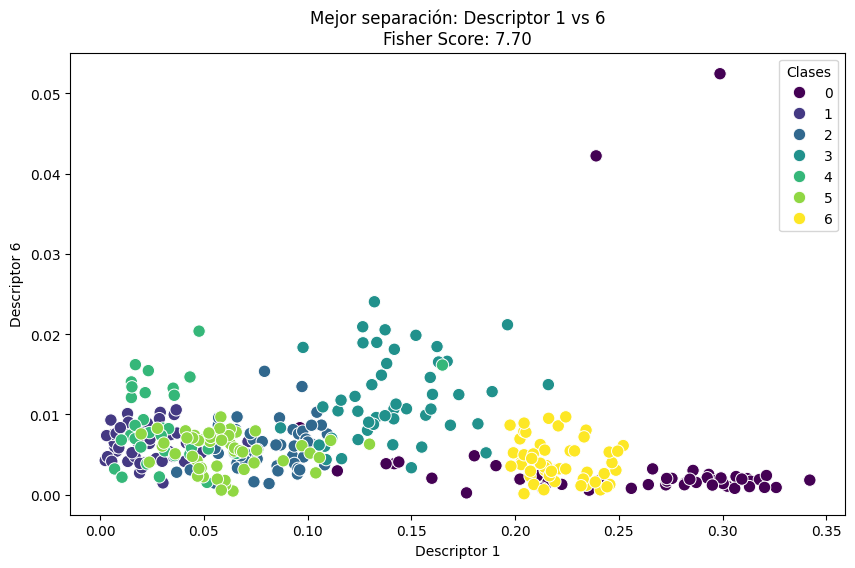

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import pairwise_distances
import seaborn as sns

# 1. Calcular importancia individual de cada descriptor (ANOVA)
f_scores = np.zeros(M)
for i in range(M):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X[:, i].reshape(-1, 1), y)
    f_scores[i] = np.mean(lda.score(X[:, i].reshape(-1, 1), y))

# Top 5 descriptores individuales
top_descriptors = np.argsort(f_scores)[-5:][::-1]
print("Top 5 descriptores individuales:", top_descriptors)

# 2. Evaluar pares de descriptores con Score de Fisher
def fisher_score(X_pair, y):
    overall_mean = np.mean(X_pair, axis=0)
    S_b = 0  # Between-class scatter
    S_w = 0  # Within-class scatter
    for cls in np.unique(y):
        X_cls = X_pair[y == cls]
        mean_cls = np.mean(X_cls, axis=0)
        S_b += len(X_cls) * np.outer((mean_cls - overall_mean), (mean_cls - overall_mean))
        S_w += np.cov(X_cls.T, bias=True) * (len(X_cls) - 1)
    return np.trace(S_b) / np.trace(S_w)

# Probar combinaciones de los top 5 descriptores
best_pair = None
best_score = -1
for i in range(len(top_descriptors)):
    for j in range(i+1, len(top_descriptors)):
        pair = (top_descriptors[i], top_descriptors[j])
        score = fisher_score(X[:, pair], y)
        if score > best_score:
            best_score = score
            best_pair = pair

print(f"\nMejor par de descriptores: {best_pair} (Fisher Score: {best_score:.2f})")

# Graficar el mejor par
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X[:, best_pair[0]], y=X[:, best_pair[1]], hue=y, palette='viridis', s=80)
plt.title(f'Mejor separación: Descriptor {best_pair[0]} vs {best_pair[1]}\nFisher Score: {best_score:.2f}')
plt.xlabel(f'Descriptor {best_pair[0]}')
plt.ylabel(f'Descriptor {best_pair[1]}')
plt.legend(title='Clases')
plt.show()

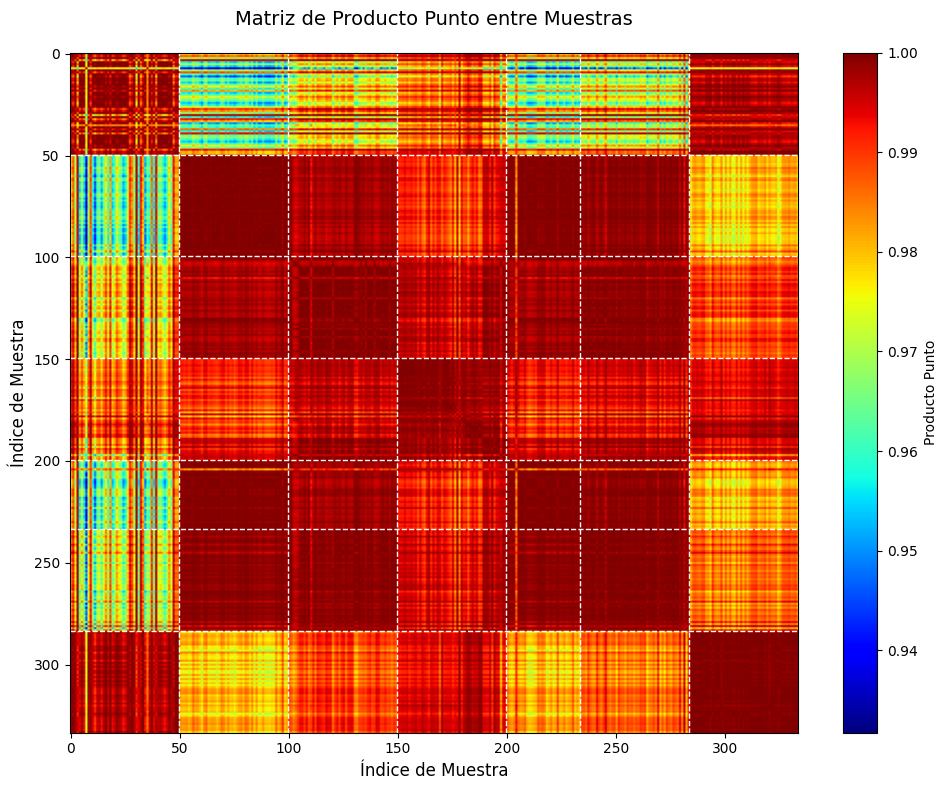

In [22]:


# 1. Calcular matriz de producto punto
D = np.dot(X, X.T)

# 2. Configuración del gráfico
plt.figure(figsize=(10, 8))
plt.imshow(D, cmap='jet', aspect='auto')

# 3. Personalización visual
plt.colorbar(label='Producto Punto')
plt.title('Matriz de Producto Punto entre Muestras', pad=20, fontsize=14)
plt.xlabel('Índice de Muestra', fontsize=12)
plt.ylabel('Índice de Muestra', fontsize=12)

# 4. Líneas divisorias entre clases
class_changes = np.where(np.diff(y))[0] + 1
for change in class_changes:
    plt.axhline(change - 0.5, color='white', linestyle='--', linewidth=1)
    plt.axvline(change - 0.5, color='white', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()